# Deep learning - hw1
- 0756708 孫茂勛

In [1]:
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import copy

Using TensorFlow backend.


### 1. Data processing

In [2]:
df = pd.read_csv('./titanic.csv')

In [3]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,1,22.0,1,0,7.2500
1,1,1,0,38.0,1,0,71.2833
2,1,3,0,26.0,0,0,7.9250
3,1,1,0,35.0,1,0,53.1000
4,0,3,1,35.0,0,0,8.0500


In [4]:
training_set = df[:800]
testing_set = df[800:]

X_train = training_set[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']].values
X_test = testing_set[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']].values
X_train = X_train.reshape(X_train.shape[0], -1, 1)
X_test = X_test.reshape(X_test.shape[0], -1, 1)

y_train = training_set['Survived'].values
y_test = testing_set['Survived'].values
y_train = to_categorical(y_train).reshape(y_train.shape[0], -1, 1)
y_test = to_categorical(y_test).reshape(y_test.shape[0], -1, 1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# combine data & labels 
training_data = list(zip(X_train, y_train))
testing_data = list(zip(X_test, y_test))

(800, 6, 1) (800, 2, 1)
(91, 6, 1) (91, 2, 1)


### 2. Model Architecture

In [5]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def sigmoid_derivate(z):
    return sigmoid(z) * (1-sigmoid(z))

def cross_entropy(output, ground_truth):
    return np.sum( np.nan_to_num( -ground_truth*np.log(output) - (1-ground_truth)*np.log(1-output) ) )

def cross_entropy_derivative(output, ground_truth):
    return output - ground_truth

In [6]:
class NN():
    def __init__(self, neurons):
        self.num_layers = len(neurons)
        self.neurons = neurons
        # create weights & bias
        self.weights = [ np.zeros((j, i)) for i, j in zip(neurons[:-1], neurons[1:]) ]
        self.biases = [ np.zeros((i, 1)) for i in neurons[1:] ]
        # info 
        self.training_loss = []
        self.training_error_rate = []
        self.testing_error_rate = []
    
    def SGD(self, training_data, testing_data, epochs, batch_size, lr):

        num = len(training_data)
        self.training_loss = []
        self.training_error_rate = []
        self.testing_error_rate = []
        
        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []
        
        for epoch in range(epochs):
            random.shuffle(training_data)
            mini_batch = [ training_data[i : i + batch_size] for i in range(0, num, batch_size) ] # split data into mini_batch
            for single_data in mini_batch:
                self.update_mini_batch(single_data, lr)
            
            if (epoch % 50 == 0):
                # record info
                self.training_loss.append(self.calc_loss(training_data))
                self.training_error_rate.append(self.count_error(training_data) / len(training_data))
                self.testing_error_rate.append(self.count_error(testing_data) / len(testing_data))
                print('===================================')
                print("【Epoch %s】" % epoch) 
                print('    training loss: %f' % self.calc_loss(training_data))
                print('    training error rate: %d / %d(%f)' % (self.count_error(training_data), len(training_data), self.count_error(training_data) / len(training_data)))
                print('    testing error rate: %d / %d(%f)' % (self.count_error(testing_data), len(testing_data), self.count_error(testing_data) / len(testing_data)))
                
    
    def update_mini_batch(self, single_data, lr):
        sum_gradient_w = [ np.zeros(w.shape) for w in self.weights ]
        sum_gradient_b = [ np.zeros(b.shape) for b in self.biases ]
        
        # cumulate gradient of each single data
        for x, y in single_data:
            gradient_w, gradient_b = self.backward(x, y)
            sum_gradient_w = [  sw + w for sw, w in zip(sum_gradient_w, gradient_w)]
            sum_gradient_b = [ sb + b for sb, b in zip(sum_gradient_b, gradient_b)]
        
        # update weights & biases with (mean of sum of gradient * learning rate)
        self.weights = [ w - lr/len(single_data) * sw for w, sw in zip(self.weights, sum_gradient_w) ]
        self.biases = [ b - lr/len(single_data) * sb for b, sb in zip(self.biases, sum_gradient_b) ]
    
    def forward(self, x):
        for w, b in zip(self.weights, self.biases):
            x = np.dot(w, x) + b
            x = sigmoid(x)
        return x
    
    def backward(self, x, y):
        # store gradient of w, b
        gradient_w = [ np.zeros(w.shape) for w in self.weights ]
        gradient_b = [ np.zeros(b.shape) for b in self.biases ]
        
        # forward
        activation = x
        zs = [] # store vectors which is input of activation function
        activations = [x] # store vectors which is output of activation function
        
        for w, b in zip(self.weights, self.biases):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
            
        # backward 
        # we calc last layer separately, because loss function is diff with activation funcion
        delta = cross_entropy_derivative(activations[-1], y)
        gradient_b[-1] = delta * 1
        gradient_w[-1] = np.dot(delta, activations[-2].T)
        for layer in range(2, self.num_layers):
            z = zs[-layer]
            delta = np.dot(self.weights[-layer + 1].T, delta) * sigmoid_derivate(z)
            gradient_w[-layer] = np.dot(delta, activations[-layer - 1].T)
            gradient_b[-layer] = delta
        return gradient_w, gradient_b
        
    def calc_loss(self, data):
        # calc cross entropy loss
        loss = 0
        for x, y in data:
            output = self.forward(x)
            loss += cross_entropy(output, y)/ len(data)
        return loss
    
    def count_error(self, data):
        # count error number
        compare_list = [ (np.argmax(self.forward(x)), np.argmax(y)) for x, y in data ]
        error_count = sum( int(y1 != y2) for y1, y2 in compare_list)
        return error_count 

### 3. Training

#### p1

In [7]:
module1 = NN([6, 32, 32, 64, 2])
module1.SGD(training_data, testing_data, 3000, 100, 0.3)

【Epoch 0】
    training loss: 1.347053
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 91(0.373626)
【Epoch 50】
    training loss: 1.344135
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 91(0.373626)
【Epoch 100】
    training loss: 1.339753
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 91(0.373626)
【Epoch 150】
    training loss: 1.329431
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 91(0.373626)
【Epoch 200】
    training loss: 1.279102
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 91(0.373626)
【Epoch 250】
    training loss: 1.219769
    training error rate: 262 / 800(0.327500)
    testing error rate: 26 / 91(0.285714)
【Epoch 300】
    training loss: 1.424017
    training error rate: 285 / 800(0.356250)
    testing error rate: 32 / 91(0.351648)
【Epoch 350】
    training loss: 1.133523
    training error rate: 237 / 800(0.296250)
    testing error rate: 24 / 

【Epoch 2550】
    training loss: 0.941177
    training error rate: 154 / 800(0.192500)
    testing error rate: 18 / 91(0.197802)
【Epoch 2600】
    training loss: 0.945638
    training error rate: 161 / 800(0.201250)
    testing error rate: 17 / 91(0.186813)
【Epoch 2650】
    training loss: 0.975377
    training error rate: 169 / 800(0.211250)
    testing error rate: 18 / 91(0.197802)
【Epoch 2700】
    training loss: 1.028503
    training error rate: 188 / 800(0.235000)
    testing error rate: 22 / 91(0.241758)
【Epoch 2750】
    training loss: 1.050562
    training error rate: 196 / 800(0.245000)
    testing error rate: 20 / 91(0.219780)
【Epoch 2800】
    training loss: 0.965189
    training error rate: 162 / 800(0.202500)
    testing error rate: 19 / 91(0.208791)
【Epoch 2850】
    training loss: 0.938445
    training error rate: 157 / 800(0.196250)
    testing error rate: 18 / 91(0.197802)
【Epoch 2900】
    training loss: 0.939912
    training error rate: 158 / 800(0.197500)
    testing error 

In [8]:
new_x_axis = np.arange(0,3000, 50)

Text(0, 0.5, 'Average cross entropy')

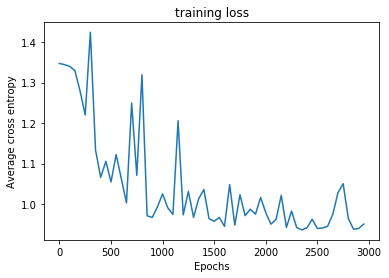

In [9]:
fig, ax = plt.subplots(1, 1)
ax.plot(new_x_axis, module1.training_loss)
ax.set_title('training loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Average cross entropy')

Text(0, 0.5, 'Error rate')

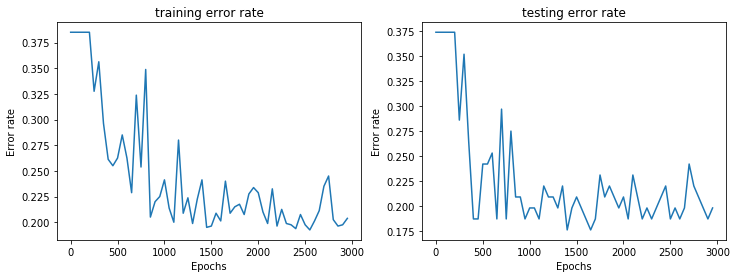

In [10]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
ax[0].plot(new_x_axis, module1.training_error_rate)
ax[0].set_title('training error rate')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Error rate')

ax[1].plot(new_x_axis, module1.testing_error_rate)
ax[1].set_title('testing error rate')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rate')

#### p2

In [11]:
module2 = NN([6, 3, 3, 2])

In [12]:
module2.SGD(training_data, testing_data, 3000, 100, 0.03)

【Epoch 0】
    training loss: 1.376259
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 91(0.373626)
【Epoch 50】
    training loss: 1.332859
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 91(0.373626)
【Epoch 100】
    training loss: 1.332620
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 91(0.373626)
【Epoch 150】
    training loss: 1.332084
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 91(0.373626)
【Epoch 200】
    training loss: 1.331055
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 91(0.373626)
【Epoch 250】
    training loss: 1.329397
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 91(0.373626)
【Epoch 300】
    training loss: 1.326865
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 91(0.373626)
【Epoch 350】
    training loss: 1.323153
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 

【Epoch 2550】
    training loss: 0.978235
    training error rate: 171 / 800(0.213750)
    testing error rate: 20 / 91(0.219780)
【Epoch 2600】
    training loss: 0.960258
    training error rate: 168 / 800(0.210000)
    testing error rate: 18 / 91(0.197802)
【Epoch 2650】
    training loss: 0.995808
    training error rate: 180 / 800(0.225000)
    testing error rate: 19 / 91(0.208791)
【Epoch 2700】
    training loss: 0.958065
    training error rate: 162 / 800(0.202500)
    testing error rate: 17 / 91(0.186813)
【Epoch 2750】
    training loss: 0.957253
    training error rate: 160 / 800(0.200000)
    testing error rate: 17 / 91(0.186813)
【Epoch 2800】
    training loss: 0.989404
    training error rate: 179 / 800(0.223750)
    testing error rate: 20 / 91(0.219780)
【Epoch 2850】
    training loss: 0.987161
    training error rate: 165 / 800(0.206250)
    testing error rate: 19 / 91(0.208791)
【Epoch 2900】
    training loss: 0.978045
    training error rate: 174 / 800(0.217500)
    testing error 

Text(0, 0.5, 'Average cross entropy')

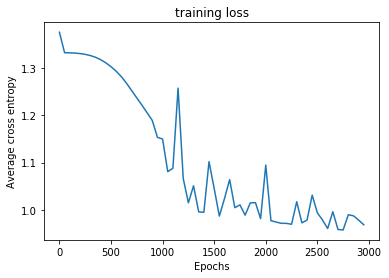

In [13]:
fig, ax = plt.subplots(1, 1)
ax.plot(new_x_axis, module2.training_loss)
ax.set_title('training loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Average cross entropy')

Text(0, 0.5, 'Error rate')

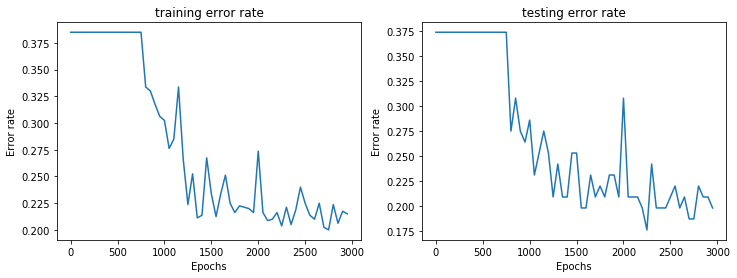

In [14]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
ax[0].plot(new_x_axis, module2.training_error_rate)
ax[0].set_title('training error rate')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Error rate')

ax[1].plot(new_x_axis, module2.testing_error_rate)
ax[1].set_title('testing error rate')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rate')

#### p4

In [15]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,1,22.0,1,0,7.2500
1,1,1,0,38.0,1,0,71.2833
2,1,3,0,26.0,0,0,7.9250
3,1,1,0,35.0,1,0,53.1000
4,0,3,1,35.0,0,0,8.0500


In [16]:
module2.weights[0]

array([[ 0.48034168,  4.39749411,  0.01074326,  0.70127273,  0.34607828,
        -0.05292099],
       [ 0.48034168,  4.39749411,  0.01074326,  0.70127273,  0.34607828,
        -0.05292099],
       [ 0.48034168,  4.39749411,  0.01074326,  0.70127273,  0.34607828,
        -0.05292099]])

#### p3.

In [17]:
df_new = df.copy()
df_new.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,1,22.0,1,0,7.2500
1,1,1,0,38.0,1,0,71.2833
2,1,3,0,26.0,0,0,7.9250
3,1,1,0,35.0,1,0,53.1000
4,0,3,1,35.0,0,0,8.0500


In [18]:
from sklearn.preprocessing import StandardScaler

In [19]:
fare_scaler = StandardScaler()
df_new['Fare'] = pd.DataFrame(fare_scaler.fit_transform(df_new['Fare'].values.reshape(-1,1)))

In [20]:
df_new.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,1,22.0,1,0,-0.502445
1,1,1,0,38.0,1,0,0.786845
2,1,3,0,26.0,0,0,-0.488854
3,1,1,0,35.0,1,0,0.420730
4,0,3,1,35.0,0,0,-0.486337


In [22]:
training_set = df_new[:800]
testing_set = df_new[800:]

X_train = training_set[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']].values
X_test = testing_set[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']].values
X_train = X_train.reshape(X_train.shape[0], -1, 1)
X_test = X_test.reshape(X_test.shape[0], -1, 1)

y_train = training_set['Survived'].values
y_test = testing_set['Survived'].values
y_train = to_categorical(y_train).reshape(y_train.shape[0], -1, 1)
y_test = to_categorical(y_test).reshape(y_test.shape[0], -1, 1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# combine data & labels 
training_data = list(zip(X_train, y_train))
testing_data = list(zip(X_test, y_test))

(800, 6, 1) (800, 2, 1)
(91, 6, 1) (91, 2, 1)


In [23]:
module3 = NN([6, 3, 3, 2])
module3.SGD(training_data, testing_data, 3000, 100, 0.1)

【Epoch 0】
    training loss: 1.359142
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 91(0.373626)
【Epoch 50】
    training loss: 1.332919
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 91(0.373626)
【Epoch 100】
    training loss: 1.332917
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 91(0.373626)
【Epoch 150】
    training loss: 1.332917
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 91(0.373626)
【Epoch 200】
    training loss: 1.332917
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 91(0.373626)
【Epoch 250】
    training loss: 1.332917
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 91(0.373626)
【Epoch 300】
    training loss: 1.332916
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 91(0.373626)
【Epoch 350】
    training loss: 1.332914
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 

【Epoch 2550】
    training loss: 1.042190
    training error rate: 197 / 800(0.246250)
    testing error rate: 26 / 91(0.285714)
【Epoch 2600】
    training loss: 1.060585
    training error rate: 186 / 800(0.232500)
    testing error rate: 17 / 91(0.186813)
【Epoch 2650】
    training loss: 0.926642
    training error rate: 150 / 800(0.187500)
    testing error rate: 18 / 91(0.197802)
【Epoch 2700】
    training loss: 0.931730
    training error rate: 152 / 800(0.190000)
    testing error rate: 18 / 91(0.197802)
【Epoch 2750】
    training loss: 0.939486
    training error rate: 157 / 800(0.196250)
    testing error rate: 18 / 91(0.197802)
【Epoch 2800】
    training loss: 0.929057
    training error rate: 153 / 800(0.191250)
    testing error rate: 17 / 91(0.186813)
【Epoch 2850】
    training loss: 0.905953
    training error rate: 148 / 800(0.185000)
    testing error rate: 19 / 91(0.208791)
【Epoch 2900】
    training loss: 0.909468
    training error rate: 153 / 800(0.191250)
    testing error 

In [24]:
new_x_axis = np.arange(0, 3000, 50)

Text(0, 0.5, 'Average cross entropy')

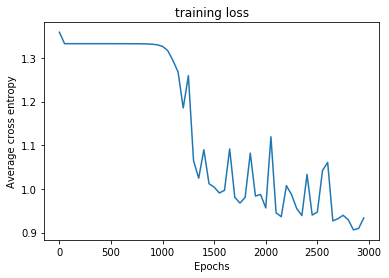

In [25]:
fig, ax = plt.subplots(1, 1)
ax.plot(new_x_axis, module3.training_loss)
ax.set_title('training loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Average cross entropy')

Text(0, 0.5, 'Error rate')

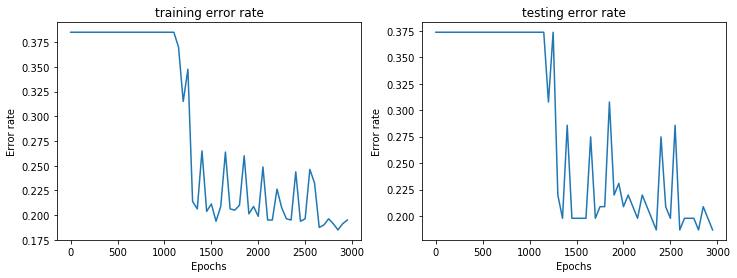

In [26]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
ax[0].plot(new_x_axis, module3.training_error_rate)
ax[0].set_title('training error rate')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Error rate')

ax[1].plot(new_x_axis, module3.testing_error_rate)
ax[1].set_title('testing error rate')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rate')

#### p3-2

In [27]:
df_new_1 = df.copy()

In [28]:
fare_scaler = StandardScaler()
age_scaler = StandardScaler()
df_new_1['Fare'] = pd.DataFrame(fare_scaler.fit_transform(df_new_1['Fare'].values.reshape(-1,1)))
df_new_1['Age'] = pd.DataFrame(age_scaler.fit_transform(df_new_1['Age'].values.reshape(-1,1)))

In [29]:
training_set = df_new_1[:800]
testing_set = df_new_1[800:]

X_train = training_set[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']].values
X_test = testing_set[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']].values
X_train = X_train.reshape(X_train.shape[0], -1, 1)
X_test = X_test.reshape(X_test.shape[0], -1, 1)

y_train = training_set['Survived'].values
y_test = testing_set['Survived'].values
y_train = to_categorical(y_train).reshape(y_train.shape[0], -1, 1)
y_test = to_categorical(y_test).reshape(y_test.shape[0], -1, 1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# combine data & labels 
training_data = list(zip(X_train, y_train))
testing_data = list(zip(X_test, y_test))

(800, 6, 1) (800, 2, 1)
(91, 6, 1) (91, 2, 1)


In [30]:
module4 = NN([6, 3, 3, 2])
module4.SGD(training_data, testing_data, 3000, 100, 0.1)

【Epoch 0】
    training loss: 1.359158
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 91(0.373626)
【Epoch 50】
    training loss: 1.332920
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 91(0.373626)
【Epoch 100】
    training loss: 1.332931
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 91(0.373626)
【Epoch 150】
    training loss: 1.332918
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 91(0.373626)
【Epoch 200】
    training loss: 1.332923
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 91(0.373626)
【Epoch 250】
    training loss: 1.332917
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 91(0.373626)
【Epoch 300】
    training loss: 1.332918
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 91(0.373626)
【Epoch 350】
    training loss: 1.332915
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 

【Epoch 2550】
    training loss: 0.877378
    training error rate: 150 / 800(0.187500)
    testing error rate: 19 / 91(0.208791)
【Epoch 2600】
    training loss: 0.877202
    training error rate: 150 / 800(0.187500)
    testing error rate: 19 / 91(0.208791)
【Epoch 2650】
    training loss: 0.877070
    training error rate: 148 / 800(0.185000)
    testing error rate: 19 / 91(0.208791)
【Epoch 2700】
    training loss: 0.877334
    training error rate: 148 / 800(0.185000)
    testing error rate: 20 / 91(0.219780)
【Epoch 2750】
    training loss: 0.877248
    training error rate: 148 / 800(0.185000)
    testing error rate: 20 / 91(0.219780)
【Epoch 2800】
    training loss: 0.877027
    training error rate: 149 / 800(0.186250)
    testing error rate: 19 / 91(0.208791)
【Epoch 2850】
    training loss: 0.877070
    training error rate: 149 / 800(0.186250)
    testing error rate: 19 / 91(0.208791)
【Epoch 2900】
    training loss: 0.877471
    training error rate: 151 / 800(0.188750)
    testing error 

Text(0, 0.5, 'Average cross entropy')

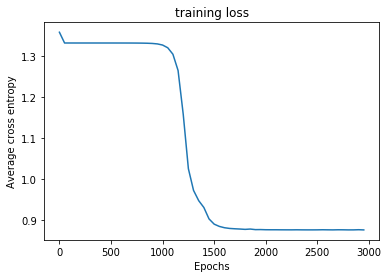

In [31]:
fig, ax = plt.subplots(1, 1)
ax.plot(new_x_axis, module4.training_loss)
ax.set_title('training loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Average cross entropy')

Text(0, 0.5, 'Error rate')

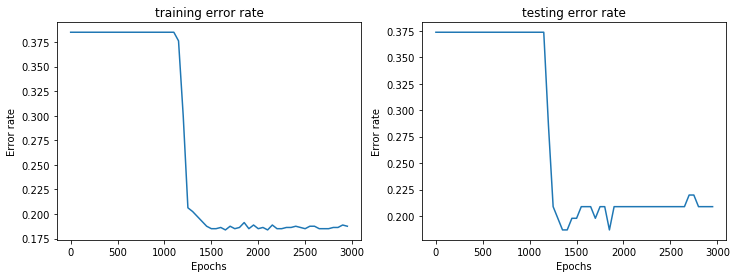

In [32]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
ax[0].plot(new_x_axis, module4.training_error_rate)
ax[0].set_title('training error rate')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Error rate')

ax[1].plot(new_x_axis, module4.testing_error_rate)
ax[1].set_title('testing error rate')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rate')

#### p5

In [33]:
df_new_2 = pd.get_dummies(df_new_1, columns=['Pclass'])

In [34]:
df_new_2.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3
0,0,1,-0.102313,1,0,-0.502445,0,0,1
1,1,0,0.807492,1,0,0.786845,1,0,0
2,1,0,0.125138,0,0,-0.488854,0,0,1
3,1,0,0.636903,1,0,0.420730,1,0,0
4,0,1,0.636903,0,0,-0.486337,0,0,1


In [36]:
training_set = df_new_2[:800]
testing_set = df_new_2[800:]

X_train = training_set[['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']].values
X_test = testing_set[['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']].values
X_train = X_train.reshape(X_train.shape[0], -1, 1)
X_test = X_test.reshape(X_test.shape[0], -1, 1)

y_train = training_set['Survived'].values
y_test = testing_set['Survived'].values
y_train = to_categorical(y_train).reshape(y_train.shape[0], -1, 1)
y_test = to_categorical(y_test).reshape(y_test.shape[0], -1, 1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# combine data & labels 
training_data = list(zip(X_train, y_train))
testing_data = list(zip(X_test, y_test))

(800, 8, 1) (800, 2, 1)
(91, 8, 1) (91, 2, 1)


In [37]:
module5 = NN([8, 3, 3, 2])
module5.SGD(training_data, testing_data, 3000, 100, 0.1)

【Epoch 0】
    training loss: 1.359803
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 91(0.373626)
【Epoch 50】
    training loss: 1.332921
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 91(0.373626)
【Epoch 100】
    training loss: 1.332921
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 91(0.373626)
【Epoch 150】
    training loss: 1.332924
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 91(0.373626)
【Epoch 200】
    training loss: 1.332931
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 91(0.373626)
【Epoch 250】
    training loss: 1.332918
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 91(0.373626)
【Epoch 300】
    training loss: 1.332918
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 91(0.373626)
【Epoch 350】
    training loss: 1.332918
    training error rate: 308 / 800(0.385000)
    testing error rate: 34 / 

【Epoch 2550】
    training loss: 0.876453
    training error rate: 148 / 800(0.185000)
    testing error rate: 19 / 91(0.208791)
【Epoch 2600】
    training loss: 0.876441
    training error rate: 150 / 800(0.187500)
    testing error rate: 19 / 91(0.208791)
【Epoch 2650】
    training loss: 0.876443
    training error rate: 150 / 800(0.187500)
    testing error rate: 19 / 91(0.208791)
【Epoch 2700】
    training loss: 0.876455
    training error rate: 147 / 800(0.183750)
    testing error rate: 19 / 91(0.208791)
【Epoch 2750】
    training loss: 0.876444
    training error rate: 149 / 800(0.186250)
    testing error rate: 19 / 91(0.208791)
【Epoch 2800】
    training loss: 0.876441
    training error rate: 148 / 800(0.185000)
    testing error rate: 19 / 91(0.208791)
【Epoch 2850】
    training loss: 0.876443
    training error rate: 150 / 800(0.187500)
    testing error rate: 19 / 91(0.208791)
【Epoch 2900】
    training loss: 0.876484
    training error rate: 153 / 800(0.191250)
    testing error 

In [38]:
new_x_axis = np.arange(0, 3000, 50)

Text(0, 0.5, 'Average cross entropy')

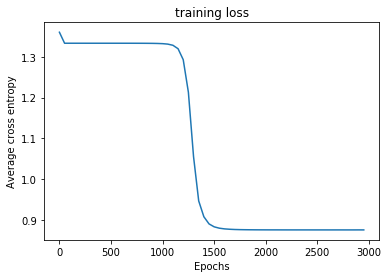

In [39]:
fig, ax = plt.subplots(1, 1)
ax.plot(new_x_axis, module5.training_loss)
ax.set_title('training loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Average cross entropy')

Text(0, 0.5, 'Error rate')

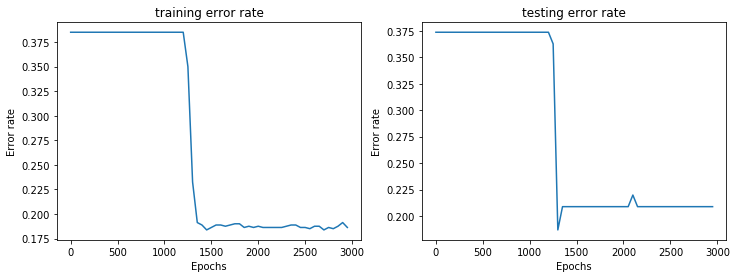

In [40]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
ax[0].plot(new_x_axis, module5.training_error_rate)
ax[0].set_title('training error rate')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Error rate')

ax[1].plot(new_x_axis, module5.testing_error_rate)
ax[1].set_title('testing error rate')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rate')

#### p6.

In [41]:
# X_train = training_set[['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']].values

In [42]:
X_train[1]

array([[1.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.80749164],
       [1.        ],
       [0.        ],
       [0.78684529]])

In [62]:
people_John = np.array([[0, 0, 1, 1, age_scaler.transform([[23]]), 2, 2, fare_scaler.transform([[0.87]])]]).reshape(-1, 1)
print(people_John)

[[ 0.        ]
 [ 0.        ]
 [ 1.        ]
 [ 1.        ]
 [-0.04545002]
 [ 2.        ]
 [ 2.        ]
 [-0.63090448]]


In [63]:
prediction_john = module5.forward(people_John)
print('John死亡的機率vs存活的機率:', prediction_john[0], prediction_john[1] )

John死亡的機率vs存活的機率: [0.87382879] [0.12617121]


In [64]:
people_Angela = np.array([[1, 0, 0, 0, age_scaler.transform([[18]]), 1, 2, fare_scaler.transform([[20]])]]).reshape(-1, 1)
print(people_Angela)

[[ 1.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.3297639 ]
 [ 1.        ]
 [ 2.        ]
 [-0.24572791]]


In [65]:
prediction_Angela = module5.forward(people_Angela)
print('Angela死亡的機率vs存活的機率:', prediction_Angela[0], prediction_Angela[1] )

Angela死亡的機率vs存活的機率: [0.03808093] [0.96191907]
